###컴퓨터에게 단어를 이해시키기
- 시소러스(사람이 만든 유의어 사전)
- 통계 기반
- 추론 기반

###시소러스
- 유의어를 한 그룹으로 분류
- 단어들의 관계를 그래프로 표현하여 단어 사이의 연결 정의
- ex) WordNet

- 문제점
    - 시대 변화에 대응 어려움
    - 구성을 위한 인건비 많이 듬
    - 단어의 미묘한 차이 표현 불가

###통계 기반
- 말뭉치(corpus)
    - 자연어 처리를 위해 수집된 텍스트 데이터


In [1]:
#Example
text = 'You say goodbye and I say hello.'
text = text.lower()
text = text.replace('.', ' .')
text

'you say goodbye and i say hello .'

In [2]:
words = text.split(' ')
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [3]:
#단어 -> ID//ID-> 단어 dictionary 만들기
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

print(id_to_word)
print(word_to_id)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}


In [4]:
#단어 목록 -> 단어 id 목록
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
print(corpus)

[0 1 2 3 4 1 5 6]


In [3]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}

    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    
    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

단어 -> 벡터로 표현
올바른 벡터 표현을 단어에서 구축 가능할까? (RGB를 보고 대충 무슨색인지 알 수있는 느낌)
단어의 의미를 정확하게 파악할 수 있는 벡터 표현 --> 분산표현

분포가설 : 단어의 의미는 주변 단어에 의해 형성된다
-> 단어가 사용된 맥락(context)이 의미를 형성

동시 발생 행렬 -> 각 단어마다 동시에 발생하는 맥락이 있는 단어의 빈도

In [2]:
#동시발생행렬 구하기
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size=len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size+1):
            left_idx = idx-1
            right_idx = idx+1

            if left_idx>=0:
                left_world_id = corpus[left_idx]
                co_matrix[word_id, left_world_id] +=1

            if right_idx<corpus_size:
                right_world_id = corpus[right_idx]
                co_matrix[word_id, right_world_id] += 1
            

    return co_matrix



In [23]:
#벡터간 유사도를 구하기 위한 cosine similarity : 단어 벡터 유사도를 구할 떄 자주 사용
def cos_similarity(x, y, eps=1e-8):
    nx = x/ (np.sqrt(np.sum(x**2))+eps)
    ny = y/ (np.sqrt(np.sum(y**2))+eps)
    return np.dot(nx,ny)

In [9]:
#you단어 벡터와 i 단어벡터의 단어유사도 구해보기
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0,c1))

0.7071067691154799


In [21]:
#유사 단어의 랭킹 표시
#어떤 단어가 검색어로 주어지면, 그 검색어와 비슷한 단어를 유사도 순으로 출력

def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    if query not in word_to_id:
        print('Can\'t find the word %s.'%query)
        return
    
    print('\n[query] '+query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    #cos similarity 계산
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    #cos similarity top 5
    count = 0
    for i in (-1*similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s'%(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

In [12]:
#argsort() : 배열의 원소를 오름차순으로 정렬하고 배열의 인덱스를 반환
x = np.array([100, -20, 2])
print(x.argsort())

[1 2 0]
[100 -20   2]


In [13]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


How to improve? 
빈도 수가 높은 단어는 어떤 단어와도 높은 관련성을 갖게됨
--> 
Pointwise Mutual Information
PMI(x,y)=log_2(P(x,y)/P(x)P(y))

= log_2(C(x,y)/N / C(x)/N c(y)/N) = log_2(C(x,y)*N/C(x)*C(y)) where C is co-occurence matrix

-> 단어가 단독으로 출연하는 횟수를 고려 ( 총 출연 횟수 중에서 맥락이 있는 비율 )

C(x,y)=0 이면 -inf로 가기 떄문에
PPMI를 주로 사용
PPMI(x,y) = max(0, PMI(x,y))



In [1]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt =0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i,j]*N / (S[j]*S[i]) + eps)
            M[i,j] = max(0, pmi)
            if verbose:
                cnt+=1
                if cnt % (total//100+1) ==0:
                    print('%.1f%% 완료'%(100*cnt/total))

    return M

In [4]:
import numpy as np

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)
print('Co-occurence Matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

Co-occurence Matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


PPMI는 어휘 수 만큼 matrix의 dimension이 증가하는 문제가 있음
그리고 0이 매우 많음 ( sparse matrix )

##dimensionality reduction
with Singular Value Decomposition


In [5]:
import matplotlib.pyplot as plt

In [10]:
U,S,V = np.linalg.svd(W)

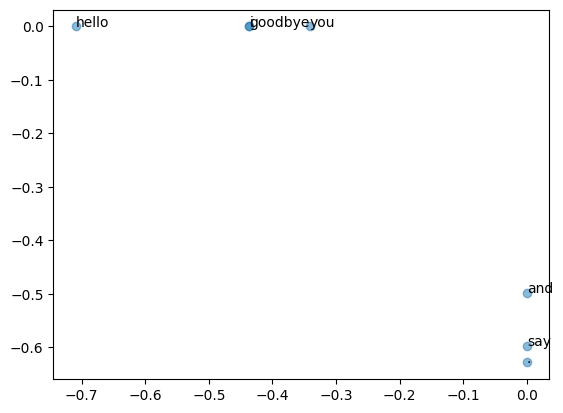

In [11]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id,0], U[word_id,1]))

plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

More Dataset
Penn Treebank : PTB



In [12]:
import sys
sys.path.append('..')
from dataset import ptb

In [13]:
corpus, word_to_id, id_to_word = ptb.load_data('train')

Done


In [14]:
print('Corpus size: ', len(corpus))
print('corpus[:30]: ', corpus[:30])

Corpus size:  929589
corpus[:30]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


In [15]:
print('id_to_word[0]: ', id_to_word[0])
print('id_to_word[1]: ', id_to_word[1])
print('id_to_word[2]: ', id_to_word[2])

id_to_word[0]:  aer
id_to_word[1]:  banknote
id_to_word[2]:  berlitz


In [20]:
print("word_to_id['car']: ", word_to_id['car'] )
print("word_to_id['happy']: ", word_to_id['happy'] )
print("word_to_id['lexus']: ", word_to_id['lexus'] )


word_to_id['car']:  3856
word_to_id['happy']:  4428
word_to_id['lexus']:  7426


In [22]:
import sys
sys.path.append('..')
from dataset import ptb
import numpy as np

window_size=2
wordvec_size=100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('Calculate Co-occurence matrix...')
C= create_co_matrix(corpus,vocab_size,window_size)
print('Calculate PPMI')
W= ppmi(C, verbose=True)

print('Calculate SVD.,')
try:
    from sklearn.utils.extmath import randomized_svd
    U,S,V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)

except ImportError:
    U,S,V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

Calculate Co-occurence matrix...
Calculate PPMI


<ipython-input-1-26454d9747a5>:10: RuntimeWarning: overflow encountered in long_scalars
  pmi = np.log2(C[i,j]*N / (S[j]*S[i]) + eps)
<ipython-input-1-26454d9747a5>:10: RuntimeWarning: invalid value encountered in log2
  pmi = np.log2(C[i,j]*N / (S[j]*S[i]) + eps)


1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
Calculate SVD.,


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject



[query] you


NameError: name 'cos_similarity' is not defined

In [24]:
print('Calculate SVD.,')
try:
    from sklearn.utils.extmath import randomized_svd
    U,S,V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)

except ImportError:
    U,S,V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

Calculate SVD.,

[query] you
 i: 0.8385523557662964
 we: 0.8213281631469727
 they: 0.6829677820205688
 anybody: 0.5464674234390259
 never: 0.5040555596351624

[query] year
 week: 0.8183932900428772
 month: 0.7884305119514465
 day: 0.7063018679618835
 quarter: 0.6569077372550964
 summer: 0.6348399519920349

[query] car
 auto: 0.664126992225647
 truck: 0.6157069802284241
 disk-drive: 0.5736684799194336
 semiconductor: 0.553277313709259
 airbus: 0.5465822219848633

[query] toyota
 kuwait: 0.6895991563796997
 aeroflot: 0.6363446116447449
 bullets: 0.6048320531845093
 itel: 0.6015076041221619
 narcotics: 0.5916672945022583
